In [65]:
import pandas as pd
import numpy as np
import pickle
import os
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                        roc_curve, auc, roc_auc_score, log_loss)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [66]:
data_path = "/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/pipeline/data_extracted_features/three_class_pp_5s_0.5.csv"
features = pd.read_csv(data_path)
features.drop(columns=['center_time', 'start_time', 'end_time'], inplace=True)

In [67]:
X = features.drop(columns=['label', 'experiment_id'])
y = features['label']
groups = features['experiment_id']

splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
groups_train, groups_test = groups.iloc[train_idx], groups.iloc[test_idx]

In [68]:
y_train

0       pre-void
1       pre-void
2       pre-void
3       pre-void
4       pre-void
         ...    
810         void
811         void
812         void
813    post-void
814    post-void
Name: label, Length: 662, dtype: object

In [69]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [70]:
y_train

array([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 1, 2,
       2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [71]:
select_feature = SelectKBest(f_classif, k=20).fit(X_train, y_train)
selected_features_df = pd.DataFrame({'Feature':list(X_train.columns),
                                    'Scores':select_feature.scores_})
selected_features_df.sort_values(by='Scores', ascending=False)

,Feature,Scores
81,gyr_y_hjorth_frequency,75.673145
78,gyr_y_spectral_spread,71.743960
11,acc_x_spectral_flatness,70.653630
98,gyr_z_hjorth_frequency,70.087865
95,gyr_z_spectral_spread,65.791367
...,...,...
15,acc_x_spectral_kurtosis,8.093034
28,acc_y_spectral_flatness,7.958113
33,acc_y_snr,5.893061
87,gyr_z_mean,3.946727


### XGBoost

In [72]:
model = XGBClassifier(
    n_estimators=178,
    max_depth=6,
    learning_rate=0.01473503255,
    subsample=0.7191610385,
    colsample_bytree=0.6846566304,
    min_child_weight=5,
    gamma=4.099517426,
    reg_alpha=0.5269345086,
    reg_lambda=1.156503782,
)

In [73]:
X_train_selected = select_feature.transform(X_train)
X_test_selected = select_feature.transform(X_test)

In [74]:
model.fit(X_train_selected, y_train)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.6846566304
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [75]:
# classes = ['non-void', 'void']

In [76]:
classes = ['non-void', 'void']
# y_pred = label_encoder.inverse_transform(model.predict(X_test_selected))
y_pred = model.predict(X_test_selected)
y_pred_prob = model.predict_proba(X_test_selected)
y_pred_labels = label_encoder.inverse_transform(np.argmax(y_pred_prob, axis=1))
report = classification_report(y_test, y_pred, labels=[0, 1])
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.39      0.33      0.36       103
           1       0.16      0.24      0.19        46
           2       0.79      0.71      0.75        94

    accuracy                           0.46       243
   macro avg       0.44      0.43      0.43       243
weighted avg       0.50      0.46      0.48       243



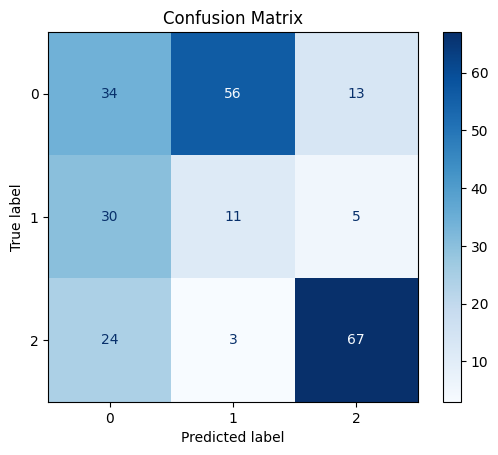

In [77]:
labels_ordered = ['void', 'non-void']
# Confusion matrix with void on top
cm = confusion_matrix(y_test, y_pred)  # [void, non-void]
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
plt.show()

### RandomForest

In [78]:
# select_feature = SelectKBest(f_classif, k=20).fit(X_train, y_train)
# selected_features_df = pd.DataFrame({'Feature':list(X_train.columns),
#                                     'Scores':select_feature.scores_})
# selected_features_df.sort_values(by='Scores', ascending=False)

In [79]:
# X_train_selected = select_feature.transform(X_train)
# X_test_selected = select_feature.transform(X_test)

In [80]:
# model = RandomForestClassifier(
#         n_estimators=255,
#         max_depth=8,
#         min_samples_split=15,
#         min_samples_leaf=6,
#         max_features='log2',
#         bootstrap=True,
#         class_weight='balanced',
#         random_state=42)

In [81]:
# model.fit(X_train_selected, y_train)

In [82]:
# # classes = ['non-void', 'void']
# # y_pred = label_encoder.inverse_transform(model.predict(X_test_selected))
# y_pred = model.predict(X_test_selected)
# y_pred_prob = model.predict_proba(X_test_selected)
# y_pred_labels = label_encoder.inverse_transform(np.argmax(y_pred_prob, axis=1))
# report = classification_report(y_test, y_pred, labels=[0, 1])
# report = classification_report(y_test, y_pred)

# print(report)

In [83]:
# labels_ordered = ['void', 'non-void']
# # Confusion matrix with void on top
# cm = confusion_matrix(y_test, y_pred)  # [void, non-void]
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap='Blues')
# disp.ax_.set_title('Confusion Matrix')
# plt.show()

## Overlay predictions on original plots

In [84]:
with open('../data/df_dict_imu.pkl', 'rb') as f:
    imu_dict = pickle.load(f)
with open('../data/df_dict_urineestimate_method1.pkl', 'rb') as f:
    urine_estimates_dict = pickle.load(f)
with open('../data/df_minze_dict.pkl', 'rb') as f:
    ground_truth_dict = pickle.load(f)
    
gender = pd.read_excel('../data/demographics_uroflowmetry.xlsx', index_col=0)
gender.drop(['Age', 'Waist Circumference (cm)', 'Height (cm)', 'Weight (Kg)', 'GD Vol (ml)', 'NOTES'], axis=1, inplace=True)
sex = gender['Gender']
sex = np.array(sex)

In [85]:
groups_test.unique()

array([ 5,  9, 14, 20, 25, 26, 30, 40, 41])

In [86]:
voids = {
    'subj_1_void7': 5, 
    'subj_2_void2': 9,
    'subj_2_void7': 14,
    'subj_3_void8': 20,
    'subj_5_void2': 25,
    'subj_5_void3': 26,
    'subj_8_void1': 30,
    'subj_15_void1': 40,
    'subj_16_void1': 41
}

In [87]:
# Keep everything together for easier analysis
test_results = pd.DataFrame({
    'group': groups_test,
    'actual': y_test,
    'predicted': y_pred
})

In [88]:
features_df = pd.read_csv("/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/pipeline/data_extracted_features/three_class_pp_5s_0.5.csv")

In [89]:
def plot_predictions_with_timing(features_df, predicted_labels, ax_pred):
    """
    Plot predictions using exact timing info from features DataFrame
    features_df and predicted_labels are already filtered for one instance
    """
    # Plot each prediction window
    void_label_added = False
    post_void_label_added = False
    pre_void_label_added = False
    
    for i, prediction in enumerate(predicted_labels):
        # Get timing info from features (convert seconds to ms to match your time axis)
        start_time = features_df.iloc[i]['start_time'] 
        # start_time = features_df.iloc[i]['center_time']
        end_time = features_df.iloc[i]['end_time'] 
        
        # Plot as colored spans
        if prediction == 2:  # Void prediction
            ax_pred.axvspan(start_time, end_time, alpha=0.7, color='lightgreen')
            void_label_added = True
        # elif prediction == 0:  # Post void prediction
        #     ax_pred.axvspan(start_time, end_time, alpha=0.7, color='lightcoral')
        #     post_void_label_added = True
        # elif prediction == 1:  # Pre void prediction
        #     ax_pred.axvspan(start_time, end_time, alpha=0.7, color='lightblue')
        #     pre_void_label_added = True

    
    # Set axis properties
    ax_pred.set_ylim(0, 1)
    ax_pred.set_ylabel('Predictions')
    ax_pred.set_yticks([0, 1])
    ax_pred.legend(loc='upper right')
    
    return ax_pred



Experiment ID: 5; Instance: subj_1_void7
[0, 1, 0, 0, 1, 2, 2, 2, 2, 2, 0, 1, 1]
Experiment ID: 9; Instance: subj_2_void2
[1, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0]
Experiment ID: 14; Instance: subj_2_void7
[0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 1, 0, 0, 0, 2]
Experiment ID: 20; Instance: subj_3_void8
[0, 0, 0, 0, 2, 2, 2, 2, 0, 1, 2, 0]
Experiment ID: 25; Instance: subj_5_void2
[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1]
Experiment ID: 26; Instance: subj_5_void3
[1, 0, 0, 1, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
Experiment ID: 30; Instance: subj_8_void1
[0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2]


/tmp/ipykernel_26952/3988742220.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_pred.legend(loc='upper right')


Experiment ID: 40; Instance: subj_15_void1
[1, 1, 1, 0, 0, 0, 2, 2, 0, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 0, 0, 1, 2, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1]
Experiment ID: 41; Instance: subj_16_void1
[0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


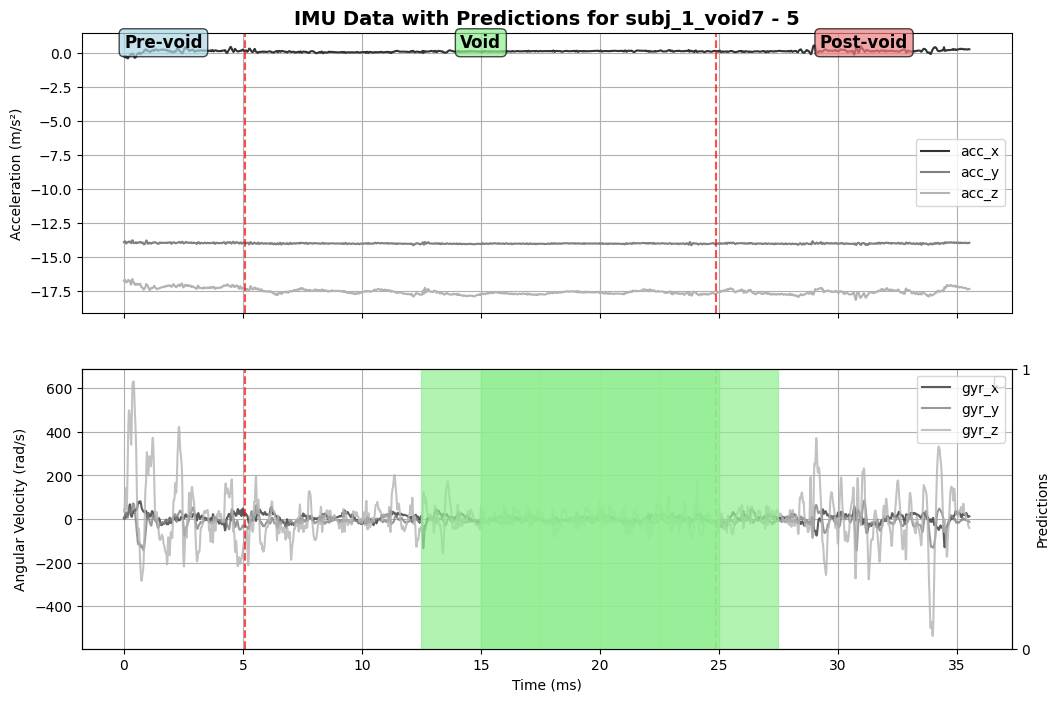

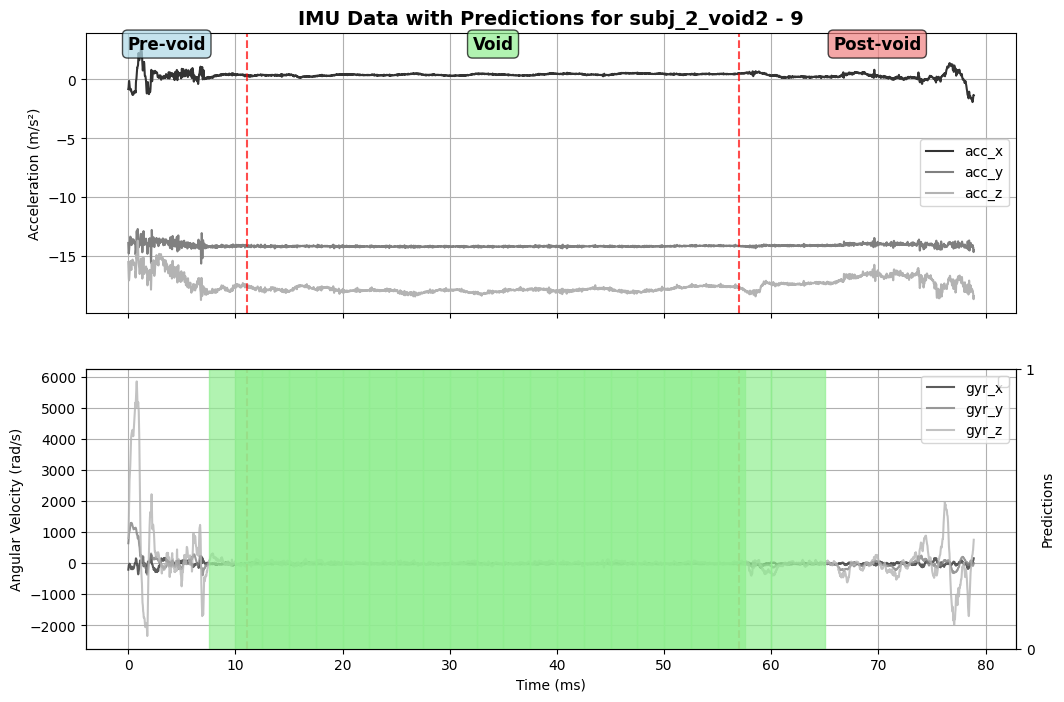

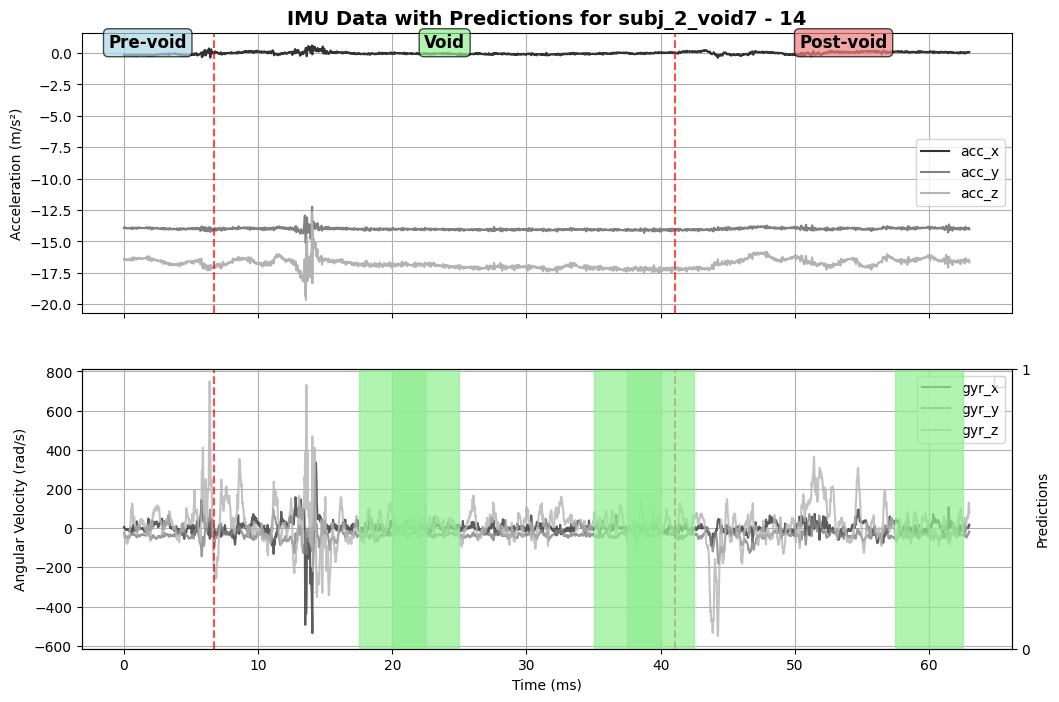

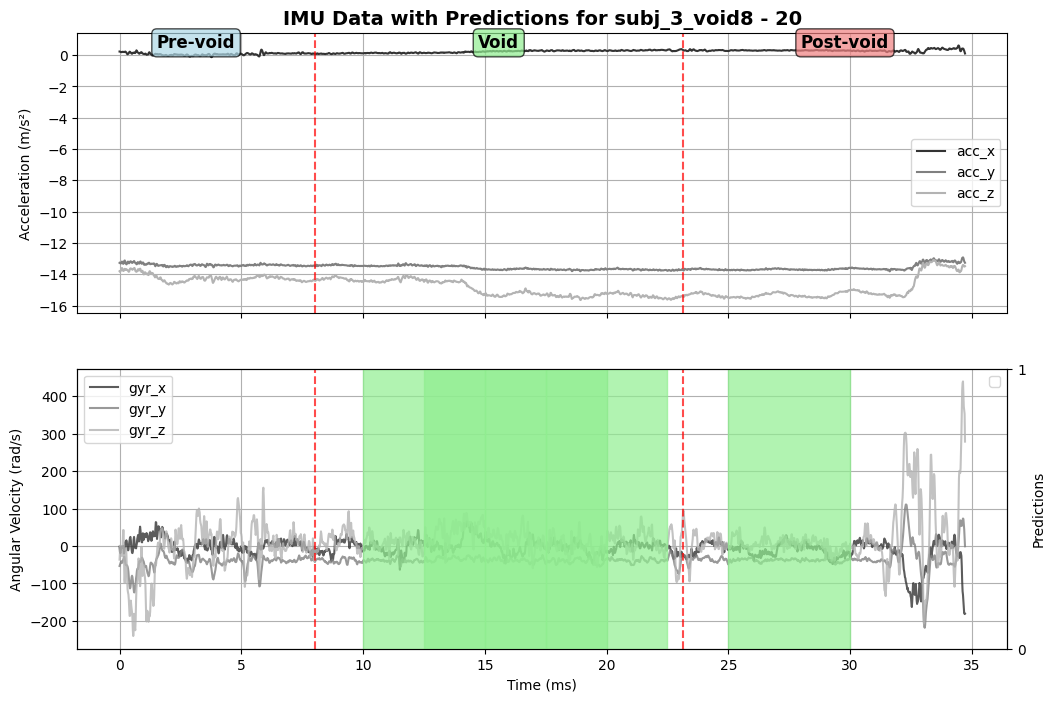

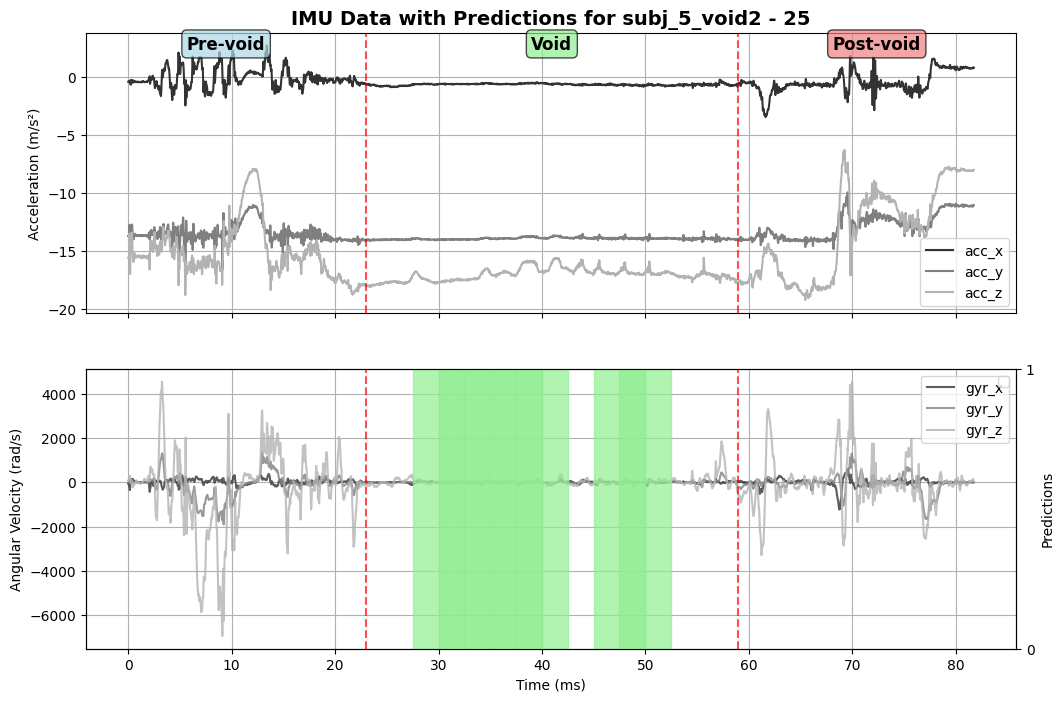

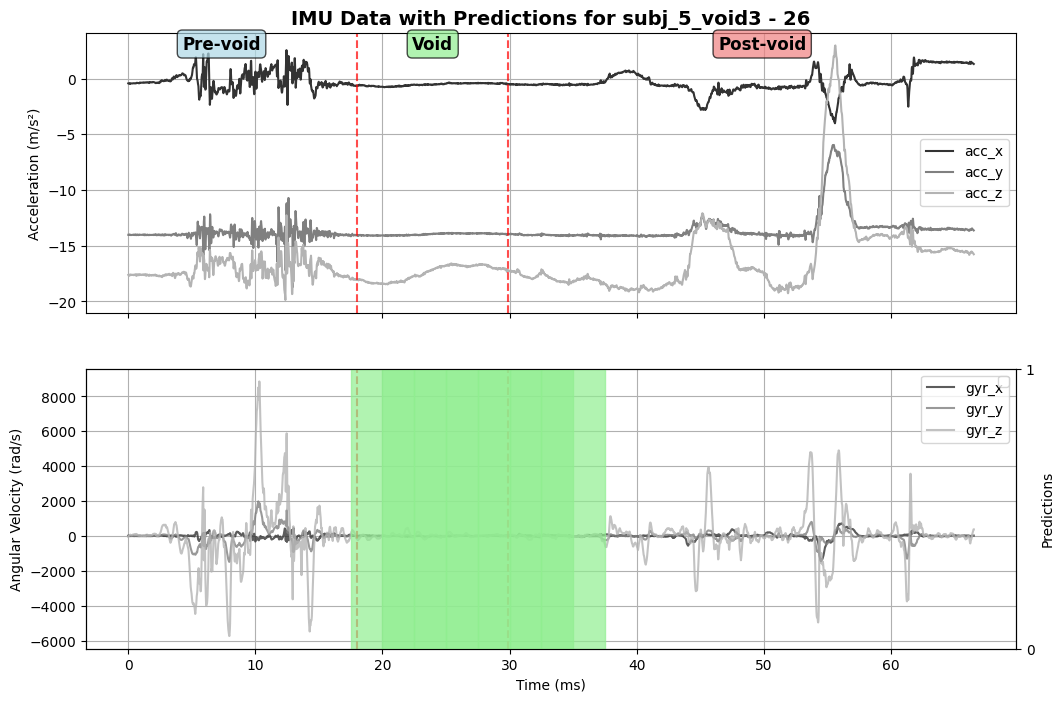

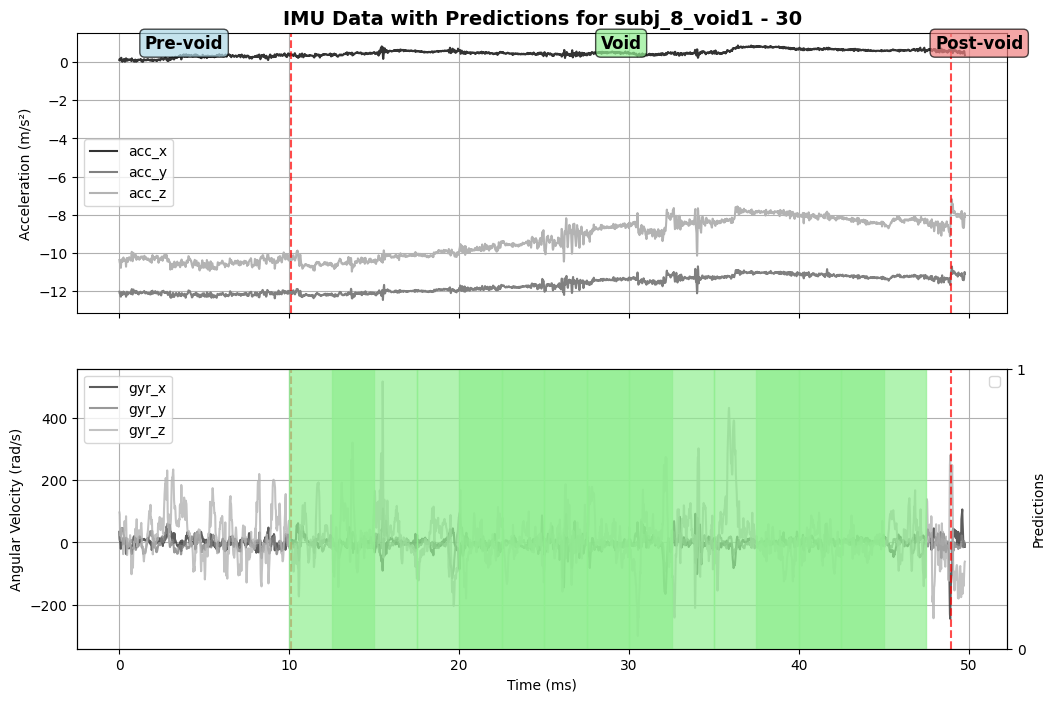

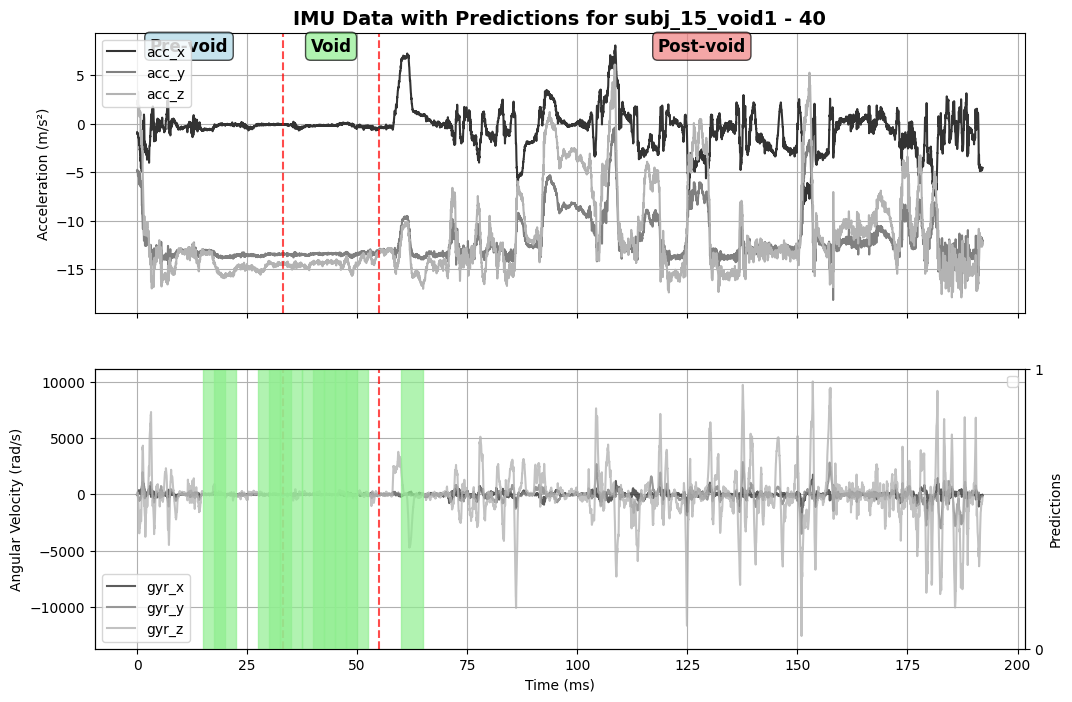

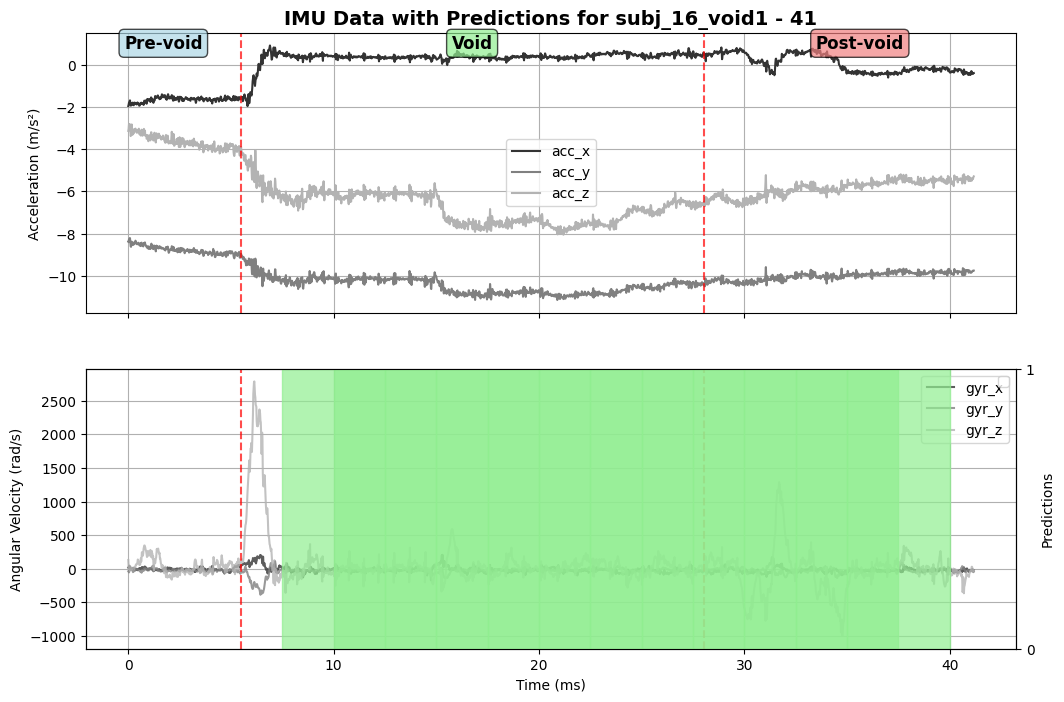

In [90]:
for i_void_instance, void_instance in enumerate(voids.keys()):
    imu_data = imu_dict[void_instance]
    urine_estimates = urine_estimates_dict[void_instance]
    ground_truth = ground_truth_dict[void_instance]
    exp_id = voids[void_instance]
    
    # Urination event is the first and last time of the ground truth data
    urination_event = [ground_truth['Time'].iloc[0], ground_truth['Time'].iloc[-1]] 
    
    # Create a figure with 2 subplots (shared x-axis)
    fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # --- Top subplot: Accelerometer ---
    ax_top.plot(imu_data['time'], imu_data['acc_x'], color='0.2', label='acc_x')
    ax_top.plot(imu_data['time'], imu_data['acc_y'], color='0.5', label='acc_y')
    ax_top.plot(imu_data['time'], imu_data['acc_z'], color='0.7', label='acc_z')
    ax_top.set_ylabel('Acceleration (m/s²)')
    ax_top.set_title(f'IMU Data with Predictions for {void_instance} - {exp_id}', fontsize=14, fontweight='bold')
    ax_top.legend(loc='best')
    ax_top.grid(True)
    
    # Add vertical lines for urination event
    ax_top.axvline(x=urination_event[0], color='red', linestyle='--', alpha=0.7)
    ax_top.axvline(x=urination_event[1], color='red', linestyle='--', alpha=0.7)
    
    # Add phase labels at the top of the top subplot only
    x_min, x_max = ax_top.get_xlim()
    y_min, y_max = ax_top.get_ylim()
    
    # Pre-void label
    pre_void_center = (x_min + urination_event[0]) / 2
    ax_top.text(pre_void_center, y_max * 0.95, 'Pre-void', ha='center', va='top', 
                fontsize=12, fontweight='bold', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))
    
    # Void label
    void_center = (urination_event[0] + urination_event[1]) / 2
    ax_top.text(void_center, y_max * 0.95, 'Void', ha='center', va='top', 
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))
    
    # Post-void label
    post_void_center = (urination_event[1] + x_max) / 2
    ax_top.text(post_void_center, y_max * 0.95, 'Post-void', ha='center', va='top', 
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.7))
    
    # --- Bottom subplot: Gyroscope ---
    ax_bottom.plot(imu_data['time'], imu_data['gyr_x'], color='0.2', label='gyr_x', alpha=0.8)
    ax_bottom.plot(imu_data['time'], imu_data['gyr_y'], color='0.5', label='gyr_y', alpha=0.8)
    ax_bottom.plot(imu_data['time'], imu_data['gyr_z'], color='0.7', label='gyr_z', alpha=0.8)
    ax_bottom.set_ylabel('Angular Velocity (rad/s)')
    ax_bottom.set_xlabel('Time (ms)')
    ax_bottom.legend(loc='best')
    ax_bottom.grid(True)
    
    # --- Overlay predictions on bottom subplot ---
    ax_pred = ax_bottom.twinx()
    predicted_labels = test_results[test_results['group'] == exp_id]['predicted'].tolist()
    actual_labels = test_results[test_results['group'] == exp_id]['actual'].tolist()
    features_df_ = features_df[features_df['experiment_id'] == exp_id]
    print(f"Experiment ID: {exp_id}; Instance: {void_instance}")
    print(predicted_labels)
    plot_predictions_with_timing(features_df_, predicted_labels, ax_pred)
    
    # Add vertical lines for urination event
    ax_bottom.axvline(x=urination_event[0], color='red', linestyle='--', alpha=0.7)
    ax_bottom.axvline(x=urination_event[1], color='red', linestyle='--', alpha=0.7)
    
    # # Save plot   
    # if not os.path.exists(acc_gyr_path):
    #     os.mkdir(acc_gyr_path)
    #     filename = os.path.join(acc_gyr_path, f'{void_instance}_acc_gyr.png')
    #     plt.savefig(filename)
    # else:
    #     filename = os.path.join(acc_gyr_path, f'{void_instance}_acc_gyr.png')
    #     plt.savefig(filename)
    # plt.close()
    
    
    # path_5s_0_5 = 'plots'
    # # Save plot   
    # if not os.path.exists(path_5s_0_5):
    #     os.mkdir(path_5s_0_5)
    #     filename = os.path.join(path_5s_0_5, f'{void_instance}_overlay.png')
    #     plt.savefig(filename)
    # else:
    #     filename = os.path.join(path_5s_0_5, f'{void_instance}_overlay.png')
    #     plt.savefig(filename)
    # plt.close()

In [91]:
# Count consecutive states in your labeled data
def analyze_state_durations(df, label_col='label'):
    durations = {'pre-void': [], 'void': [], 'post-void': []}
    
    for exp_id, group in df.groupby('experiment_id'):
        labels = group[label_col].values
        current_state = labels[0]
        duration = 1
        
        for i in range(1, len(labels)):
            if labels[i] == current_state:
                duration += 1
            else:
                durations[current_state].append(duration)
                current_state = labels[i]
                duration = 1
        durations[current_state].append(duration)  # Last state
    
    for state, durs in durations.items():
        avg_dur = np.mean(durs)
        print(f"{state}: avg {avg_dur:.1f} windows ({avg_dur*5:.1f} seconds)")
    
    return durations

In [92]:
durations = analyze_state_durations(features_df)

pre-void: avg 5.2 windows (26.2 seconds)
void: avg 9.0 windows (45.2 seconds)
post-void: avg 8.1 windows (40.5 seconds)


In [93]:
test_results

,group,actual,predicted
76,5,1,0
77,5,1,1
78,5,2,0
79,5,2,0
80,5,2,1
...,...,...,...
900,41,2,2
901,41,0,2
902,41,0,2
903,41,0,2


In [97]:
three_preds = test_results['predicted'].tolist()

In [98]:
three_preds

[0,
 1,
 0,
 0,
 1,
 2,
 2,
 2,
 2,
 2,
 0,
 1,
 1,
 1,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 1,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 0,
 0,
 0,
 2,
 2,
 0,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 1,
 2,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [94]:
# # Method 2: If windows are consecutive with known step size
# def reconstruct_with_step(predictions, window_size, step_size, start_time=0):
#     """
#     Reconstruct when you know the step size between windows
#     """
#     timeline_positions = []
#     timeline_predictions = []
    
#     for i, pred in enumerate(predictions):
#         # Calculate the center time of this window
#         window_start = start_time + (i * step_size)
#         window_center = window_start + (window_size // 2)
        
#         timeline_positions.append(window_center)
#         timeline_predictions.append(pred)
    
#     return pd.DataFrame({
#         'time_position': timeline_positions,
#         'prediction': timeline_predictions
#     })

In [95]:
# import matplotlib.pyplot as plt

# # Reconstruct your timeline
# timeline_df = reconstruct_with_step(predicted_labels, window_size=5, step_size=0.5)

# # Plot like your diagram
# plt.figure(figsize=(12, 4))

# # Plot the predictions as a timeline
# plt.step(timeline_df['time_position'], timeline_df['prediction'], 
#         where='mid', linewidth=2, label='Predicted Labels')


# plt.xlabel('Time')
# plt.ylabel('Predicted Label')
# plt.title('Timeline Reconstruction from Sliding Window Predictions')
# plt.legend()
# plt.show()

In [96]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print()